[View in Colaboratory](https://colab.research.google.com/github/buddharajuramaraju/ImageClassification-DL-Project/blob/master/ImageClassification.ipynb)

**Image Classification Project**
In this project, you'll classify images from the CIFAR-10 dataset

## **Step:1** Downloading data from source

In [57]:
from urllib.request import urlretrieve
from os.path import isfile,isdir
from tqdm import tqdm
import tarfile

    
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import random


In [58]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

In [59]:
class DLProgress(tqdm):
  last_block = 0
  
  def hook(self,block_num=1,block_size=1,total_size=None):
    self.total = total_size
    self.update((block_num-self.last_block)*block_size)
    self.last_block=block_num

In [60]:
if not isfile('cifar-10-python.tar.gz'):
  with DLProgress(unit='B',unit_scale=True,miniters=1,desc='CIFAR-10 Dataset') as pbar:
    urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz','cifar-10-python.tar.gz',pbar.hook)
                
if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()
  

## **Step:2 Data Visualization**

In [61]:
#function to unpickle images & label_names
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [62]:
#get label names from batches.meta file
label_names = unpickle("{}/batches.meta".format(cifar10_dataset_folder_path))
label_name_array=label_names[b'label_names']


In [63]:
#get images and label index from batch files
batch_num = 5 ## values 1 to 5 only
data_label = unpickle("{}/data_batch_{}".format(cifar10_dataset_folder_path,batch_num))

data = data_label[b'data']
imgs=np.asanyarray(data).astype("uint8")




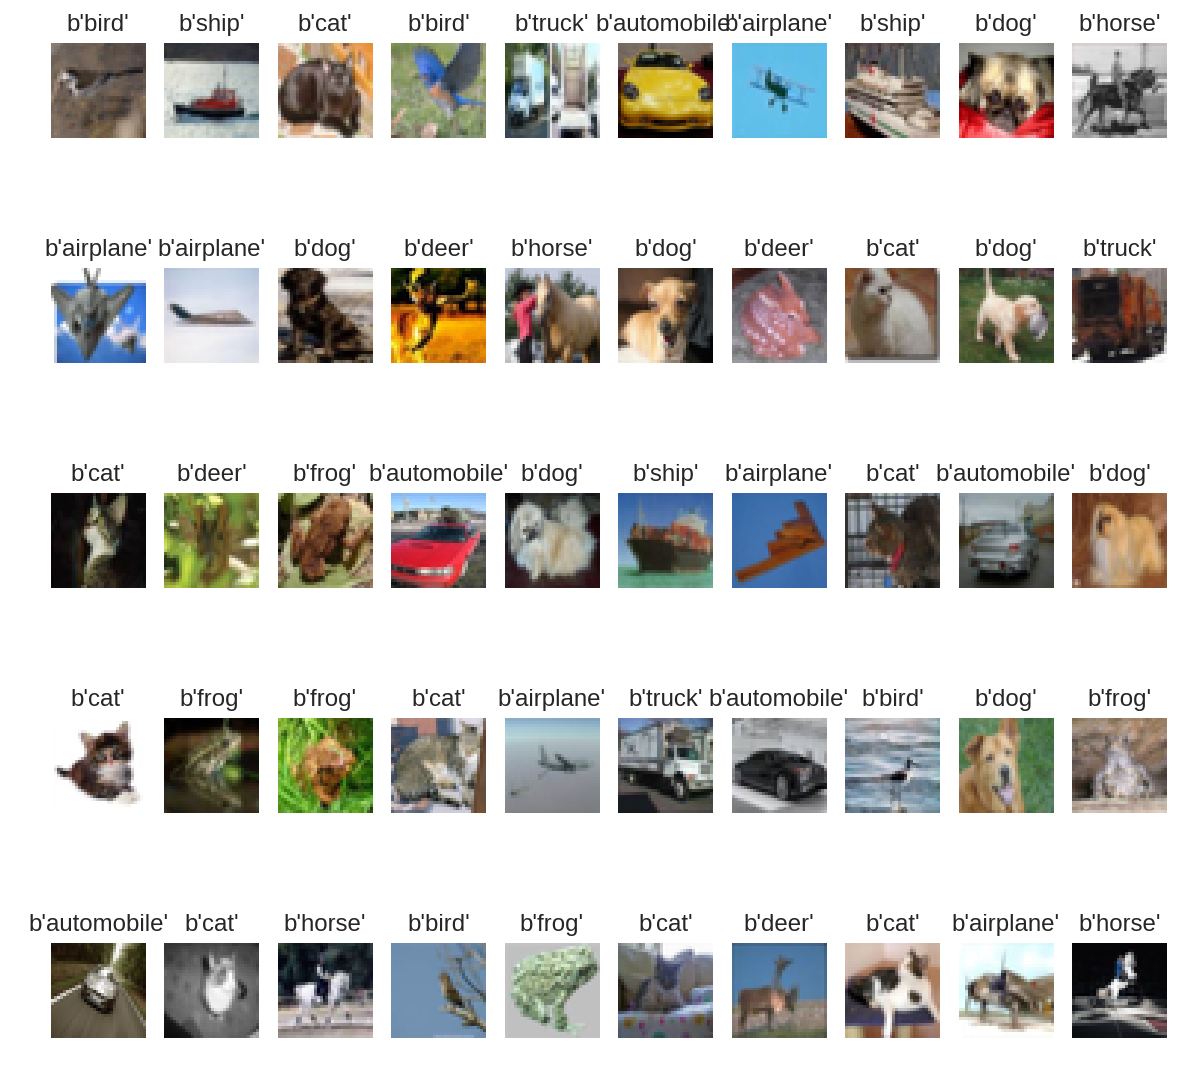

In [64]:
columns = 10
rows = 5
fig=plt.figure(figsize=(10, 10))

for i in range(1, columns*rows +1):
    num = random.randint(0,10000)
    one_img=imgs[num,:]
    img=one_img.reshape(3,32,32).transpose([1, 2, 0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    fig.gca().grid(False)
    plt.title(label_name_array[int(data_label[b'labels'][num])])

## Step:3 Data Preprocessing & Saving

In [65]:
## Function to normalize image data
## This is to convert RGB image to gray scale image of range 0 to 1
def normalize(x):
  return x/255  ## min value is 0 & max value is 255 for RGB


In [66]:
## Function for one-hot encoding 
def one_hot_encoding(x):
  return np.asarray(pd.get_dummies(x))

In [67]:
## Function to load batch from data set
def load_cifar10_batch(cifar10_dataset_folder_path,batch_num):
  data_label = unpickle("{}/data_batch_{}".format(cifar10_dataset_folder_path,batch_num))
  #print(data_label)
  features = data_label[b'data'].reshape(len(data_label[b'data']),3,32,32).transpose(0,2,3,1)
  labels = data_label[b'labels']
  return features,labels

## Function to load test data from data set
def load_cifar10_test(cifar10_dataset_folder_path):
  data_label = unpickle("{}/test_batch".format(cifar10_dataset_folder_path))
  features = data_label[b'data'].reshape(len(data_label[b'data']),3,32,32).transpose(0,2,3,1)
  labels = data_label[b'labels']
  return features,labels

In [68]:
## Function to normalize features and perform one_hot_encoding on labels
def _preprocess_and_save(normalize,one_hot_encoding,features,labels,filename):
  features = normalize(features)
  labels = one_hot_encoding(labels)
  pickle.dump((features,labels),open(filename,'wb'))

In [69]:
## Function to preprocess,split and save Traing, Validation & Test Data
def preprocess_and_save(cifar10_dataset_folder_path,normalize,one_hot_encoding):
  
  num_batches = 5
  valid_features = []
  valid_labels = []
  
  for i in range (1,num_batches+1):
    
    # Load Data from batches
    features,labels = load_cifar10_batch(cifar10_dataset_folder_path,i)
    valid_count = int(len(features)*0.1)
    
    #print(features[:-valid_count])
    #To Save Traing Data
    _preprocess_and_save(normalize,one_hot_encoding,features[:-valid_count],labels[:-valid_count],"preprocess_batch_{}.p".format(i)) 
    
    # Validation Data from batch
    valid_features.extend(features[-valid_count:])
    valid_labels.extend(labels[-valid_count:])
  
  # To Save Validation Data
  _preprocess_and_save(normalize,one_hot_encoding,np.asarray(valid_features),np.asarray(valid_labels),"preprocess_validation.p".format(i))
  
  
  # To Save Test Data 
  
  features_test,labels_test = load_cifar10_test(cifar10_dataset_folder_path)
  _preprocess_and_save(normalize,one_hot_encoding,features_test,labels_test,"preprocess_test.p".format(i))
  

  

In [70]:
## Preprocess and save Train, Validation & Test Data
preprocess_and_save(cifar10_dataset_folder_path,normalize,one_hot_encoding)

In [71]:
!ls

checkpoint				  preprocess_batch_1.p
cifar-10-batches-py			  preprocess_batch_2.p
cifar-10-python.tar.gz			  preprocess_batch_3.p
datalab					  preprocess_batch_4.p
image_classification.data-00000-of-00001  preprocess_batch_5.p
image_classification.index		  preprocess_test.p
image_classification.meta		  preprocess_validation.p


## Step:4 Implementing Input Methods

In [72]:
## Function to return batch of Image Input
def neural_net_image_input(image_shape):
  return tf.placeholder(tf.float32,shape=(None,)+image_shape,name='x')

In [73]:
## Function to return batch of Label Input
def neural_net_label_input(n_classes):
  return tf.placeholder(tf.float32,shape=(None,n_classes),name='y')

In [74]:
## Function to return keep probability for drop outs
def neural_net_keep_prob_input():
  return tf.placeholder(tf.float32,name='keep_prob')

## Step:5 Implementing Convolution and Max Pooling Layer

In [367]:
## This is to build Convolution and Max Pooling Layer
#x_tensor: input
#conv_num_outputs: Number of output from convolution layer
#conv_ksize : convolutional layer kernal size
#conv_strides : convolutionallayer Sride
#pool_ksize: max-pooling kernal size
#pool_strides: max-pooling srides 
#


def conv2d_maxpool(x_tensor,conv_num_outputs,conv_ksize,conv_strides,pool_ksize,pool_strides):
  
  ## To Caluculate weights and bias
  weights = tf.Variable(tf.truncated_normal([*conv_ksize,x_tensor.shape.as_list()[3],conv_num_outputs],stddev=5e-2))
  bias = tf.Variable(tf.zeros(conv_num_outputs))
  
  ## Convolution layer
  
  conv_layer = tf.nn.conv2d(x_tensor,weights,strides=[1,*conv_strides,1],padding='SAME')
  
  ## Add bias
  
  conv_layer = tf.nn.bias_add(conv_layer,bias)
  
  
  ## Add activation function
  
  conv_layer = tf.nn.relu(conv_layer)
  
  
  ## Add max-pooling 
  
  conv_layer = tf.nn.max_pool(conv_layer,ksize=[1,*pool_ksize,1],strides=[1,*pool_strides,1],padding='SAME')
  
  return conv_layer
  
  
  
  
  
  
  
  

## Step:6 Implementing Flatten Layer 

In [368]:
def flatten(x_tensor):
  return tf.contrib.layers.flatten(x_tensor) ## Using tensorflow flatten function

## Step:7 Implementing Fully Connected Layer

In [369]:
def fully_conn(x_tensor,num_outputs):
  return tf.layers.dense(x_tensor,num_outputs)

## Step:8 Implementing Output Layer

In [370]:
def output(x_tensor,num_outputs):
  return tf.layers.dense(x_tensor,num_outputs)

## Step:9 Implementing Convolution Network

In [470]:
def conv_net(x,keep_prob):
  
  # Apply 3 convolutional layers
  
  
  ## Convolution Layer-1
  x = conv2d_maxpool(x,64,(5,5),(1,1),(3,3),(2,2))
  x = tf.layers.dropout(x,rate=keep_prob)
  
  ## Convolution Layer-2
  x = conv2d_maxpool(x,64,(5,5),(1,1),(3,3),(2,2))
  x = tf.layers.dropout(x,rate=keep_prob)
  
  ## Convolution Layer-3
  #x = conv2d_maxpool(x,64,(5,5),(1,1),(3,3),(2,2))
  #x = tf.layers.dropout(x,rate=keep_prob)
  
  
  # Apply Flatten Layer
  x = flatten(x)
  
  
  
  # Apply 3 Fully Connected Layers
  
  #x = fully_conn(x,768)
  x = fully_conn(x,384)
  x = fully_conn(x,192)
  #x = fully_conn(x,86)
  #x = fully_conn(x,43)
  
  
  # Apply output Layer
  
  x = output(x,10)
  
  return x
  

## Step 10: Implement Tensorflow Neural Network

In [471]:
tf.reset_default_graph()

In [472]:
#Inputs
x = neural_net_image_input((32,32,3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

In [473]:
logits = conv_net(x,keep_prob)

In [474]:
logits = tf.identity(logits,name="logits")

In [475]:
## Loss and Optimizer 
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)
#optimizer = tf.train.GradientDescentOptimizer(0.00001).minimize(cost)

In [476]:
## Accuracy
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

## Step:11 Train Network

In [477]:
def train_network(session,optimizer,keep_probability,feature_batch,label_batch):
  session.run(optimizer,feed_dict={x:feature_batch,y:label_batch,keep_prob:keep_probability})
  

In [478]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [479]:
def print_status(session,feature_batch,label_batch,cost,accuracy):
  
  #Calculate Loss
  loss = session.run(cost,feed_dict={x:feature_batch,y:label_batch,keep_prob:1.0})
  #Calculate accuracy
  valid_acc = session.run(accuracy,feed_dict={x:valid_features,y:valid_labels,keep_prob:1.0})
  # Print
  print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,valid_acc))
  

**Hyperparameters**

In [480]:
epochs = 100
batch_size = 256
keep_probability = 0.75

In [481]:
## Function to split and return data into batches
def batch_features_labels(features, labels, batch_size):
     for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [482]:
## Function to load preprocess_training_batch
def load_preprocess_train_batch(batch_id,batch_size):
  filename = "preprocess_batch_{}.p".format(batch_id)
  #print(filename)
  features,labels = pickle.load(open(filename,'rb'))
  #print(features)
  return batch_features_labels(features, labels, batch_size)

### Test train model on Single Batch

In [483]:
## Test run on Batch-1 
print("Testing batch-1")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        #print(epoch)
        batch_i = 1
        #print("-->",load_preprocess_train_batch(batch_i, batch_size).size())
        for batch_features, batch_labels in load_preprocess_train_batch(batch_i, batch_size):
            #print(batch_labels)
            train_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_status(sess, batch_features, batch_labels, cost, accuracy)

Testing batch-1
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.0324 Validation Accuracy: 0.319400
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.6902 Validation Accuracy: 0.395200
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.4656 Validation Accuracy: 0.458200
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.2351 Validation Accuracy: 0.478800
Epoch  5, CIFAR-10 Batch 1:  Loss:     1.0491 Validation Accuracy: 0.505400
Epoch  6, CIFAR-10 Batch 1:  Loss:     0.8658 Validation Accuracy: 0.539800
Epoch  7, CIFAR-10 Batch 1:  Loss:     0.7392 Validation Accuracy: 0.533000
Epoch  8, CIFAR-10 Batch 1:  Loss:     0.5831 Validation Accuracy: 0.545400
Epoch  9, CIFAR-10 Batch 1:  Loss:     0.5419 Validation Accuracy: 0.548200
Epoch 10, CIFAR-10 Batch 1:  Loss:     0.4324 Validation Accuracy: 0.566600
Epoch 11, CIFAR-10 Batch 1:  Loss:     0.3410 Validation Accuracy: 0.562000
Epoch 12, CIFAR-10 Batch 1:  Loss:     0.2901 Validation Accuracy: 0.565200
Epoch 13, CIFAR-10 Batch 1:  Loss:     0.2571 Validation Accuracy: 0.556

Loss:     0.0591 Validation Accuracy: 0.548000
Epoch 37, CIFAR-10 Batch 1:  Loss:     0.0461 Validation Accuracy: 0.547800
Epoch 38, CIFAR-10 Batch 1:  Loss:     0.0249 Validation Accuracy: 0.526000
Epoch 39, CIFAR-10 Batch 1:  Loss:     0.0317 Validation Accuracy: 0.543600
Epoch 40, CIFAR-10 Batch 1:  Loss:     0.0107 Validation Accuracy: 0.547000
Epoch 41, CIFAR-10 Batch 1:  Loss:     0.0125 Validation Accuracy: 0.538400
Epoch 42, CIFAR-10 Batch 1:  Loss:     0.0146 Validation Accuracy: 0.538200
Epoch 43, CIFAR-10 Batch 1:  Loss:     0.0316 Validation Accuracy: 0.514000
Epoch 44, CIFAR-10 Batch 1:  Loss:     0.0377 Validation Accuracy: 0.537600
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.0301 Validation Accuracy: 0.542800
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.0150 Validation Accuracy: 0.542600
Epoch 47, CIFAR-10 Batch 1:  Loss:     0.0202 Validation Accuracy: 0.542000
Epoch 48, CIFAR-10 Batch 1:  Loss:     0.0069 Validation Accuracy: 0.546000
Epoch 49, CIFAR-10 Batch 1:  Loss:     0.

Epoch 72, CIFAR-10 Batch 1:  Loss:     0.0037 Validation Accuracy: 0.524400
Epoch 73, CIFAR-10 Batch 1:  Loss:     0.0066 Validation Accuracy: 0.499200
Epoch 74, CIFAR-10 Batch 1:  Loss:     0.0022 Validation Accuracy: 0.529800
Epoch 75, CIFAR-10 Batch 1:  Loss:     0.0010 Validation Accuracy: 0.549000
Epoch 76, CIFAR-10 Batch 1:  Loss:     0.0019 Validation Accuracy: 0.536200
Epoch 77, CIFAR-10 Batch 1:  Loss:     0.0008 Validation Accuracy: 0.532600
Epoch 78, CIFAR-10 Batch 1:  Loss:     0.0030 Validation Accuracy: 0.549000
Epoch 79, CIFAR-10 Batch 1:  Loss:     0.0027 Validation Accuracy: 0.534000
Epoch 80, CIFAR-10 Batch 1:  Loss:     0.0018 Validation Accuracy: 0.538600
Epoch 81, CIFAR-10 Batch 1:  Loss:     0.0042 Validation Accuracy: 0.547400
Epoch 82, CIFAR-10 Batch 1:  Loss:     0.0010 Validation Accuracy: 0.534800
Epoch 83, CIFAR-10 Batch 1:  Loss:     0.0018 Validation Accuracy: 0.538400
Epoch 84, CIFAR-10 Batch 1:  Loss:     0.0006 Validation Accuracy: 0.552800
Epoch 85, CI

### Fully train the model & saving

In [484]:
print("Training....")
save_model_path = './image_classification'

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        n_batchs = 5
        for batch_i in range(1,n_batchs+1):
                for batch_features, batch_labels in load_preprocess_train_batch(batch_i, batch_size):            
                  train_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
                print_status(sess, batch_features, batch_labels, cost, accuracy)
                  
     #Save Model 
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training....
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.9052 Validation Accuracy: 0.325200
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.5914 Validation Accuracy: 0.393000
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.4035 Validation Accuracy: 0.476400
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.2549 Validation Accuracy: 0.492600
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.4513 Validation Accuracy: 0.522600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.3447 Validation Accuracy: 0.505800
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.1895 Validation Accuracy: 0.506000
Epoch  2, CIFAR-10 Batch 3:  Loss:     0.9580 Validation Accuracy: 0.542000
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.0014 Validation Accuracy: 0.558400
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.0955 Validation Accuracy: 0.561000
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.0297 Validation Accuracy: 0.570800
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.9151 Validation Accuracy: 0.565800
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.7405 Validation Accuracy: 0.567800

Loss:     0.4385 Validation Accuracy: 0.603400
Epoch  8, CIFAR-10 Batch 2:  Loss:     0.4668 Validation Accuracy: 0.607200
Epoch  8, CIFAR-10 Batch 3:  Loss:     0.3184 Validation Accuracy: 0.639400
Epoch  8, CIFAR-10 Batch 4:  Loss:     0.4802 Validation Accuracy: 0.645800
Epoch  8, CIFAR-10 Batch 5:  Loss:     0.4128 Validation Accuracy: 0.629000
Epoch  9, CIFAR-10 Batch 1:  Loss:     0.3626 Validation Accuracy: 0.623200
Epoch  9, CIFAR-10 Batch 2:  Loss:     0.4272 Validation Accuracy: 0.612000
Epoch  9, CIFAR-10 Batch 3:  Loss:     0.2855 Validation Accuracy: 0.657400
Epoch  9, CIFAR-10 Batch 4:  Loss:     0.4437 Validation Accuracy: 0.658000
Epoch  9, CIFAR-10 Batch 5:  Loss:     0.3699 Validation Accuracy: 0.631200
Epoch 10, CIFAR-10 Batch 1:  Loss:     0.3525 Validation Accuracy: 0.642400
Epoch 10, CIFAR-10 Batch 2:  Loss:     0.3557 Validation Accuracy: 0.618400
Epoch 10, CIFAR-10 Batch 3:  Loss:     0.2652 Validation Accuracy: 0.663400
Epoch 10, CIFAR-10 Batch 4:  Loss:     0.

Epoch 15, CIFAR-10 Batch 2:  Loss:     0.2102 Validation Accuracy: 0.649800
Epoch 15, CIFAR-10 Batch 3:  Loss:     0.1668 Validation Accuracy: 0.676400
Epoch 15, CIFAR-10 Batch 4:  Loss:     0.2568 Validation Accuracy: 0.646200
Epoch 15, CIFAR-10 Batch 5:  Loss:     0.1656 Validation Accuracy: 0.640200
Epoch 16, CIFAR-10 Batch 1:  Loss:     0.2376 Validation Accuracy: 0.673800
Epoch 16, CIFAR-10 Batch 2:  Loss:     0.2032 Validation Accuracy: 0.651200
Epoch 16, CIFAR-10 Batch 3:  Loss:     0.1609 Validation Accuracy: 0.668200
Epoch 16, CIFAR-10 Batch 4:  Loss:     0.2028 Validation Accuracy: 0.655400
Epoch 16, CIFAR-10 Batch 5:  Loss:     0.1485 Validation Accuracy: 0.642400
Epoch 17, CIFAR-10 Batch 1:  Loss:     0.1901 Validation Accuracy: 0.667200
Epoch 17, CIFAR-10 Batch 2:  Loss:     0.2104 Validation Accuracy: 0.635400
Epoch 17, CIFAR-10 Batch 3:  Loss:     0.1406 Validation Accuracy: 0.677200
Epoch 17, CIFAR-10 Batch 4:  Loss:     0.1516 Validation Accuracy: 0.670200
Epoch 17, CI

Epoch 22, CIFAR-10 Batch 3:  Loss:     0.0803 Validation Accuracy: 0.677200
Epoch 22, CIFAR-10 Batch 4:  Loss:     0.1601 Validation Accuracy: 0.666600
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.1121 Validation Accuracy: 0.659800
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.1217 Validation Accuracy: 0.663600
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.1151 Validation Accuracy: 0.653600
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.0741 Validation Accuracy: 0.674600
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.1622 Validation Accuracy: 0.669800
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.0948 Validation Accuracy: 0.630600
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.1122 Validation Accuracy: 0.656200
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.1175 Validation Accuracy: 0.643200
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.0821 Validation Accuracy: 0.669400
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.1505 Validation Accuracy: 0.656000
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.0618 Validation Accuracy: 0.645600
Epoch 25, CI

Epoch 29, CIFAR-10 Batch 4:  Loss:     0.1008 Validation Accuracy: 0.648600
Epoch 29, CIFAR-10 Batch 5:  Loss:     0.0715 Validation Accuracy: 0.658600
Epoch 30, CIFAR-10 Batch 1:  Loss:     0.0588 Validation Accuracy: 0.663600
Epoch 30, CIFAR-10 Batch 2:  Loss:     0.0591 Validation Accuracy: 0.649200
Epoch 30, CIFAR-10 Batch 3:  Loss:     0.0494 Validation Accuracy: 0.649800
Epoch 30, CIFAR-10 Batch 4:  Loss:     0.0808 Validation Accuracy: 0.658000
Epoch 30, CIFAR-10 Batch 5:  Loss:     0.0520 Validation Accuracy: 0.663200
Epoch 31, CIFAR-10 Batch 1:  Loss:     0.0532 Validation Accuracy: 0.667000
Epoch 31, CIFAR-10 Batch 2:  Loss:     0.0805 Validation Accuracy: 0.642400
Epoch 31, CIFAR-10 Batch 3:  Loss:     0.0558 Validation Accuracy: 0.654800
Epoch 31, CIFAR-10 Batch 4:  Loss:     0.0705 Validation Accuracy: 0.667800
Epoch 31, CIFAR-10 Batch 5:  Loss:     0.0506 Validation Accuracy: 0.660000
Epoch 32, CIFAR-10 Batch 1:  Loss:     0.0491 Validation Accuracy: 0.651200
Epoch 32, CI

Epoch 36, CIFAR-10 Batch 5:  Loss:     0.0656 Validation Accuracy: 0.649400
Epoch 37, CIFAR-10 Batch 1:  Loss:     0.0265 Validation Accuracy: 0.658400
Epoch 37, CIFAR-10 Batch 2:  Loss:     0.0566 Validation Accuracy: 0.635000
Epoch 37, CIFAR-10 Batch 3:  Loss:     0.0505 Validation Accuracy: 0.614200
Epoch 37, CIFAR-10 Batch 4:  Loss:     0.0437 Validation Accuracy: 0.652400
Epoch 37, CIFAR-10 Batch 5:  Loss:     0.0378 Validation Accuracy: 0.657400
Epoch 38, CIFAR-10 Batch 1:  Loss:     0.0286 Validation Accuracy: 0.659400
Epoch 38, CIFAR-10 Batch 2:  Loss:     0.0378 Validation Accuracy: 0.657000
Epoch 38, CIFAR-10 Batch 3:  Loss:     0.0239 Validation Accuracy: 0.635000
Epoch 38, CIFAR-10 Batch 4:  Loss:     0.0655 Validation Accuracy: 0.646000
Epoch 38, CIFAR-10 Batch 5:  Loss:     0.0212 Validation Accuracy: 0.657000
Epoch 39, CIFAR-10 Batch 1:  Loss:     0.0314 Validation Accuracy: 0.658200
Epoch 39, CIFAR-10 Batch 2:  Loss:     0.0319 Validation Accuracy: 0.663200
Epoch 39, CI

Epoch 44, CIFAR-10 Batch 1:  Loss:     0.0222 Validation Accuracy: 0.645400
Epoch 44, CIFAR-10 Batch 2:  Loss:     0.0376 Validation Accuracy: 0.637200
Epoch 44, CIFAR-10 Batch 3:  Loss:     0.0240 Validation Accuracy: 0.640600
Epoch 44, CIFAR-10 Batch 4:  Loss:     0.0320 Validation Accuracy: 0.653800
Epoch 44, CIFAR-10 Batch 5:  Loss:     0.0615 Validation Accuracy: 0.641200
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.0228 Validation Accuracy: 0.639400
Epoch 45, CIFAR-10 Batch 2:  Loss:     0.0341 Validation Accuracy: 0.642600
Epoch 45, CIFAR-10 Batch 3:  Loss:     0.0318 Validation Accuracy: 0.631600
Epoch 45, CIFAR-10 Batch 4:  Loss:     0.0372 Validation Accuracy: 0.654600
Epoch 45, CIFAR-10 Batch 5:  Loss:     0.0363 Validation Accuracy: 0.624400
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.0410 Validation Accuracy: 0.644600
Epoch 46, CIFAR-10 Batch 2:  Loss:     0.0283 Validation Accuracy: 0.642800
Epoch 46, CIFAR-10 Batch 3:  Loss:     0.0321 Validation Accuracy: 0.628400
Epoch 46, CI

Epoch 51, CIFAR-10 Batch 2:  Loss:     0.0235 Validation Accuracy: 0.633400
Epoch 51, CIFAR-10 Batch 3:  Loss:     0.0202 Validation Accuracy: 0.647000
Epoch 51, CIFAR-10 Batch 4:  Loss:     0.0279 Validation Accuracy: 0.637000
Epoch 51, CIFAR-10 Batch 5:  Loss:     0.0137 Validation Accuracy: 0.636000
Epoch 52, CIFAR-10 Batch 1:  Loss:     0.0220 Validation Accuracy: 0.655800
Epoch 52, CIFAR-10 Batch 2:  Loss:     0.0308 Validation Accuracy: 0.641000
Epoch 52, CIFAR-10 Batch 3:  Loss:     0.0271 Validation Accuracy: 0.650200
Epoch 52, CIFAR-10 Batch 4:  Loss:     0.0366 Validation Accuracy: 0.627000
Epoch 52, CIFAR-10 Batch 5:  Loss:     0.0333 Validation Accuracy: 0.627000
Epoch 53, CIFAR-10 Batch 1:  Loss:     0.0284 Validation Accuracy: 0.658800
Epoch 53, CIFAR-10 Batch 2:  Loss:     0.0201 Validation Accuracy: 0.650600
Epoch 53, CIFAR-10 Batch 3:  Loss:     0.0276 Validation Accuracy: 0.642800
Epoch 53, CIFAR-10 Batch 4:  Loss:     0.0321 Validation Accuracy: 0.646200
Epoch 53, CI

Epoch 58, CIFAR-10 Batch 3:  Loss:     0.0127 Validation Accuracy: 0.611400
Epoch 58, CIFAR-10 Batch 4:  Loss:     0.0176 Validation Accuracy: 0.634600
Epoch 58, CIFAR-10 Batch 5:  Loss:     0.0328 Validation Accuracy: 0.628800
Epoch 59, CIFAR-10 Batch 1:  Loss:     0.0364 Validation Accuracy: 0.631000
Epoch 59, CIFAR-10 Batch 2:  Loss:     0.0090 Validation Accuracy: 0.635600
Epoch 59, CIFAR-10 Batch 3:  Loss:     0.0072 Validation Accuracy: 0.643600
Epoch 59, CIFAR-10 Batch 4:  Loss:     0.0251 Validation Accuracy: 0.632200
Epoch 59, CIFAR-10 Batch 5:  Loss:     0.0148 Validation Accuracy: 0.604400
Epoch 60, CIFAR-10 Batch 1:  Loss:     0.0460 Validation Accuracy: 0.622000
Epoch 60, CIFAR-10 Batch 2:  Loss:     0.0200 Validation Accuracy: 0.639400
Epoch 60, CIFAR-10 Batch 3:  Loss:     0.0065 Validation Accuracy: 0.632800
Epoch 60, CIFAR-10 Batch 4:  Loss:     0.0183 Validation Accuracy: 0.641600
Epoch 60, CIFAR-10 Batch 5:  Loss:     0.0376 Validation Accuracy: 0.595600
Epoch 61, CI

Epoch 65, CIFAR-10 Batch 4:  Loss:     0.0216 Validation Accuracy: 0.632800
Epoch 65, CIFAR-10 Batch 5:  Loss:     0.0152 Validation Accuracy: 0.624000
Epoch 66, CIFAR-10 Batch 1:  Loss:     0.0107 Validation Accuracy: 0.616400
Epoch 66, CIFAR-10 Batch 2:  Loss:     0.0110 Validation Accuracy: 0.649000
Epoch 66, CIFAR-10 Batch 3:  Loss:     0.0160 Validation Accuracy: 0.633800
Epoch 66, CIFAR-10 Batch 4:  Loss:     0.0144 Validation Accuracy: 0.627600
Epoch 66, CIFAR-10 Batch 5:  Loss:     0.0063 Validation Accuracy: 0.628000
Epoch 67, CIFAR-10 Batch 1:  Loss:     0.0135 Validation Accuracy: 0.638200
Epoch 67, CIFAR-10 Batch 2:  Loss:     0.0153 Validation Accuracy: 0.640000
Epoch 67, CIFAR-10 Batch 3:  Loss:     0.0078 Validation Accuracy: 0.639800
Epoch 67, CIFAR-10 Batch 4:  Loss:     0.0388 Validation Accuracy: 0.628000
Epoch 67, CIFAR-10 Batch 5:  Loss:     0.0071 Validation Accuracy: 0.632000
Epoch 68, CIFAR-10 Batch 1:  Loss:     0.0065 Validation Accuracy: 0.648000
Epoch 68, CI

Epoch 72, CIFAR-10 Batch 5:  Loss:     0.0036 Validation Accuracy: 0.633600
Epoch 73, CIFAR-10 Batch 1:  Loss:     0.0116 Validation Accuracy: 0.639600
Epoch 73, CIFAR-10 Batch 2:  Loss:     0.0054 Validation Accuracy: 0.646600
Epoch 73, CIFAR-10 Batch 3:  Loss:     0.0137 Validation Accuracy: 0.647400
Epoch 73, CIFAR-10 Batch 4:  Loss:     0.0060 Validation Accuracy: 0.648200
Epoch 73, CIFAR-10 Batch 5:  Loss:     0.0094 Validation Accuracy: 0.620600
Epoch 74, CIFAR-10 Batch 1:  Loss:     0.0134 Validation Accuracy: 0.635000
Epoch 74, CIFAR-10 Batch 2:  Loss:     0.0067 Validation Accuracy: 0.629800
Epoch 74, CIFAR-10 Batch 3:  Loss:     0.0026 Validation Accuracy: 0.628800
Epoch 74, CIFAR-10 Batch 4:  Loss:     0.0108 Validation Accuracy: 0.644000
Epoch 74, CIFAR-10 Batch 5:  Loss:     0.0022 Validation Accuracy: 0.616800
Epoch 75, CIFAR-10 Batch 1:  Loss:     0.0083 Validation Accuracy: 0.632000
Epoch 75, CIFAR-10 Batch 2:  Loss:     0.0049 Validation Accuracy: 0.631800
Epoch 75, CI

Epoch 80, CIFAR-10 Batch 1:  Loss:     0.0043 Validation Accuracy: 0.634800
Epoch 80, CIFAR-10 Batch 2:  Loss:     0.0056 Validation Accuracy: 0.641800
Epoch 80, CIFAR-10 Batch 3:  Loss:     0.0031 Validation Accuracy: 0.647000
Epoch 80, CIFAR-10 Batch 4:  Loss:     0.0100 Validation Accuracy: 0.637200
Epoch 80, CIFAR-10 Batch 5:  Loss:     0.0035 Validation Accuracy: 0.639000
Epoch 81, CIFAR-10 Batch 1:  Loss:     0.0026 Validation Accuracy: 0.635400
Epoch 81, CIFAR-10 Batch 2:  Loss:     0.0059 Validation Accuracy: 0.641400
Epoch 81, CIFAR-10 Batch 3:  Loss:     0.0076 Validation Accuracy: 0.641000
Epoch 81, CIFAR-10 Batch 4:  Loss:     0.0056 Validation Accuracy: 0.633400
Epoch 81, CIFAR-10 Batch 5:  Loss:     0.0066 Validation Accuracy: 0.629600
Epoch 82, CIFAR-10 Batch 1:  Loss:     0.0042 Validation Accuracy: 0.623400
Epoch 82, CIFAR-10 Batch 2:  Loss:     0.0082 Validation Accuracy: 0.638400
Epoch 82, CIFAR-10 Batch 3:  Loss:     0.0067 Validation Accuracy: 0.646400
Epoch 82, CI

Epoch 87, CIFAR-10 Batch 2:  Loss:     0.0069 Validation Accuracy: 0.634600
Epoch 87, CIFAR-10 Batch 3:  Loss:     0.0076 Validation Accuracy: 0.641000
Epoch 87, CIFAR-10 Batch 4:  Loss:     0.0107 Validation Accuracy: 0.640200
Epoch 87, CIFAR-10 Batch 5:  Loss:     0.0020 Validation Accuracy: 0.645400
Epoch 88, CIFAR-10 Batch 1:  Loss:     0.0006 Validation Accuracy: 0.633200
Epoch 88, CIFAR-10 Batch 2:  Loss:     0.0041 Validation Accuracy: 0.629800
Epoch 88, CIFAR-10 Batch 3:  Loss:     0.0026 Validation Accuracy: 0.642400
Epoch 88, CIFAR-10 Batch 4:  Loss:     0.0051 Validation Accuracy: 0.634200
Epoch 88, CIFAR-10 Batch 5:  Loss:     0.0025 Validation Accuracy: 0.631600
Epoch 89, CIFAR-10 Batch 1:  Loss:     0.0013 Validation Accuracy: 0.635000
Epoch 89, CIFAR-10 Batch 2:  Loss:     0.0033 Validation Accuracy: 0.642200
Epoch 89, CIFAR-10 Batch 3:  Loss:     0.0029 Validation Accuracy: 0.630200
Epoch 89, CIFAR-10 Batch 4:  Loss:     0.0049 Validation Accuracy: 0.636200
Epoch 89, CI

Epoch 94, CIFAR-10 Batch 3:  Loss:     0.0006 Validation Accuracy: 0.630200
Epoch 94, CIFAR-10 Batch 4:  Loss:     0.0045 Validation Accuracy: 0.639400
Epoch 94, CIFAR-10 Batch 5:  Loss:     0.0031 Validation Accuracy: 0.637600
Epoch 95, CIFAR-10 Batch 1:  Loss:     0.0043 Validation Accuracy: 0.635000
Epoch 95, CIFAR-10 Batch 2:  Loss:     0.0100 Validation Accuracy: 0.631800
Epoch 95, CIFAR-10 Batch 3:  Loss:     0.0007 Validation Accuracy: 0.637200
Epoch 95, CIFAR-10 Batch 4:  Loss:     0.0070 Validation Accuracy: 0.626400
Epoch 95, CIFAR-10 Batch 5:  Loss:     0.0133 Validation Accuracy: 0.623000
Epoch 96, CIFAR-10 Batch 1:  Loss:     0.0002 Validation Accuracy: 0.638400
Epoch 96, CIFAR-10 Batch 2:  Loss:     0.0016 Validation Accuracy: 0.638200
Epoch 96, CIFAR-10 Batch 3:  Loss:     0.0014 Validation Accuracy: 0.641200
Epoch 96, CIFAR-10 Batch 4:  Loss:     0.0041 Validation Accuracy: 0.641000
Epoch 96, CIFAR-10 Batch 5:  Loss:     0.0026 Validation Accuracy: 0.630200
Epoch 97, CI

In [485]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt


def _load_label_names():
  
  return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Sample Test Image Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [486]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'




save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
   

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')

        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0

        for test_feature_batch, test_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6474609375



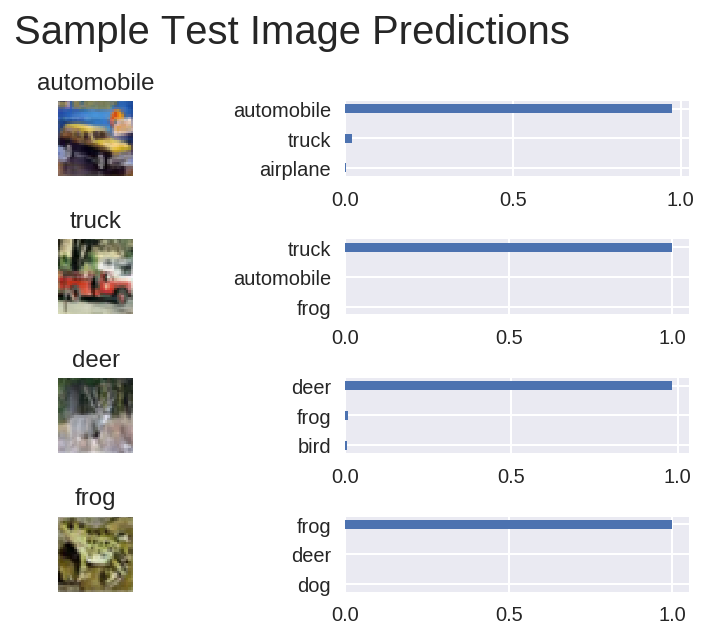

In [498]:
test_model()